In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import random
import sklearn.preprocessing
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# CLUSTERING POR DEPARTAMENTOS


### Permitira ver si hay una correlación entre divorcios y denuncias de violencia intrafamiliar en cada departamento. Este clustering nos dirá qué departamentos tienen patrones similares en términos de divorcios y violencia

In [4]:
def clean_numeric(df):
    """Convierte valores numéricos en las columnas del DataFrame."""
    for col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Cargar datos de divorcios
divorcios = pd.read_csv("../data/Divorcios por departamento.csv")
divorcios = clean_numeric(divorcios)

# Renombrar columna de total
divorcios = divorcios.rename(columns={"República": "Total_Divorcios_Republica"})

# Renombrar columnas de departamentos agregando "_Divorcios"
divorcios = divorcios.rename(columns={col: f"{col}_Divorcios" for col in divorcios.columns if col not in ["Año", "Total_Divorcios_Republica"]})

# Cargar datos de denuncias
num_intra_dep = pd.read_csv("../data/Número de denuncias de violencia intrafamiliar por departamento.csv")
num_intra_dep = clean_numeric(num_intra_dep)

# Renombrar columna de total
num_intra_dep = num_intra_dep.rename(columns={"República": "Total_Denuncias_Intrafamiliar_República"})

# Renombrar columnas de departamentos agregando "_Denuncias"
num_intra_dep = num_intra_dep.rename(columns={col: f"{col}_Denuncias" for col in num_intra_dep.columns if col not in ["Año", "Total_Denuncias_Intrafamiliar_República"]})

# Unir ambos DataFrames por "Año"
df = pd.merge(divorcios, num_intra_dep, on="Año", how="inner")

# Extraer nombres de departamentos eliminando el sufijo "_Divorcios"
departamentos = [col.replace("_Divorcios", "") for col in df.columns if col.endswith("_Divorcios")]

# Crear estructura para almacenar promedios
resultados = {"Departamento": [], "Promedio_Denuncias": [], "Promedio_Divorcios": []}

# Calcular promedios por departamento
for depto in departamentos:
    denuncias_col = f"{depto}_Denuncias"
    divorcios_col = f"{depto}_Divorcios"

    if denuncias_col in df.columns and divorcios_col in df.columns:
        promedio_denuncias = df[denuncias_col].mean()
        promedio_divorcios = df[divorcios_col].mean()

        resultados["Departamento"].append(depto)
        resultados["Promedio_Denuncias"].append(promedio_denuncias)
        resultados["Promedio_Divorcios"].append(promedio_divorcios)

# Convertir resultados en DataFrame
departamentos = pd.DataFrame(resultados)

departamentos

,Departamento,Promedio_Denuncias,Promedio_Divorcios
0,Guatemala,6059.266667,2138.733333
1,El Progreso,1019.666667,102.333333
2,Sacatepéquez,1514.200000,119.466667
3,Chimaltenango,1777.600000,116.933333
4,Escuintla,1026.933333,268.333333
5,Santa Rosa,1111.600000,158.400000
6,Sololá,701.066667,62.066667
7,Totonicapán,543.066667,99.400000
8,Quetzaltenango,1732.066667,422.133333
9,Suchitepéquez,2002.666667,215.533333


## Histograma multiple de variables

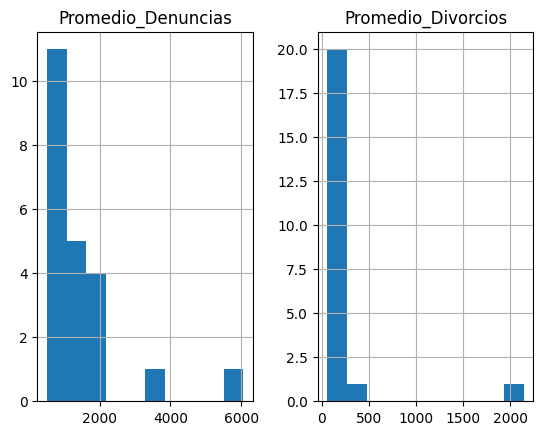

In [5]:
departamentos.drop(['Departamento'], axis='columns').hist()
plt.show()

In [6]:
Y = np.array(departamentos[['Departamento']])
X = np.array(departamentos[['Promedio_Denuncias', 'Promedio_Divorcios']])
X.shape

(22, 2)

## Estadistico de Hopkings

In [7]:
random.seed(123)
X_scaled = sklearn.preprocessing.scale(X)

def hopkins_statistic(X, sample_size=None):
    if sample_size is None:
        sample_size = int(0.1 * len(X))  # Tomar el 10% de las observaciones

    n, d = X.shape  # Número total de observaciones y dimensiones

    # Seleccionar muestras aleatorias de los datos
    np.random.seed(123)  # Fijar semilla para reproducibilidad
    sample_indices = np.random.choice(n, sample_size, replace=False)
    X_sample = X[sample_indices]

    # Generar puntos aleatorios dentro del mismo rango de valores de X
    min_vals, max_vals = X.min(axis=0), X.max(axis=0)
    X_random = np.random.uniform(low=min_vals, high=max_vals, size=(sample_size, d))

    # Calcular la distancia más cercana de cada muestra a otro punto en X
    w_distances = np.min(cdist(X_sample, X, metric='euclidean'), axis=1)

    # Calcular la distancia más cercana de cada punto aleatorio a cualquier punto en X
    u_distances = np.min(cdist(X_random, X, metric='euclidean'), axis=1)

    # Estadística de Hopkins
    hopkins_stat = np.sum(w_distances) / (np.sum(w_distances) + np.sum(u_distances))
    return hopkins_stat

# Calcular la Estadística de Hopkins
hopkins_value = hopkins_statistic(X_scaled, len(X_scaled))
print(f'Estadística de Hopkins: {hopkins_value}')

Estadística de Hopkins: 0.0


 ### Como se puede observar el estadístico de hopkings no es igual a 0.5 por lo que se dice que es factible hacer agrupamiento.

## Numero de K Clusters 

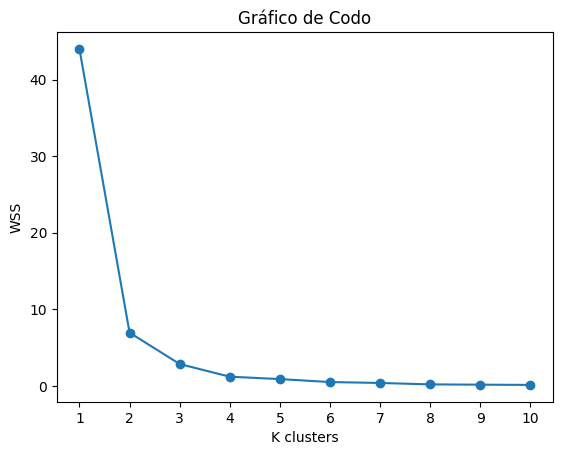

In [8]:
X_scaled = sklearn.preprocessing.scale(X)

numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

### Segun la grafica, un k = 4 es buen numero

## Analisis de Silhoutte

For n_clusters = 2 The average silhouette_score is : 0.8144559293332821
For n_clusters = 3 The average silhouette_score is : 0.5755091790301757
For n_clusters = 4 The average silhouette_score is : 0.598609523035173
For n_clusters = 5 The average silhouette_score is : 0.5463243511695134
For n_clusters = 6 The average silhouette_score is : 0.5442545216350649


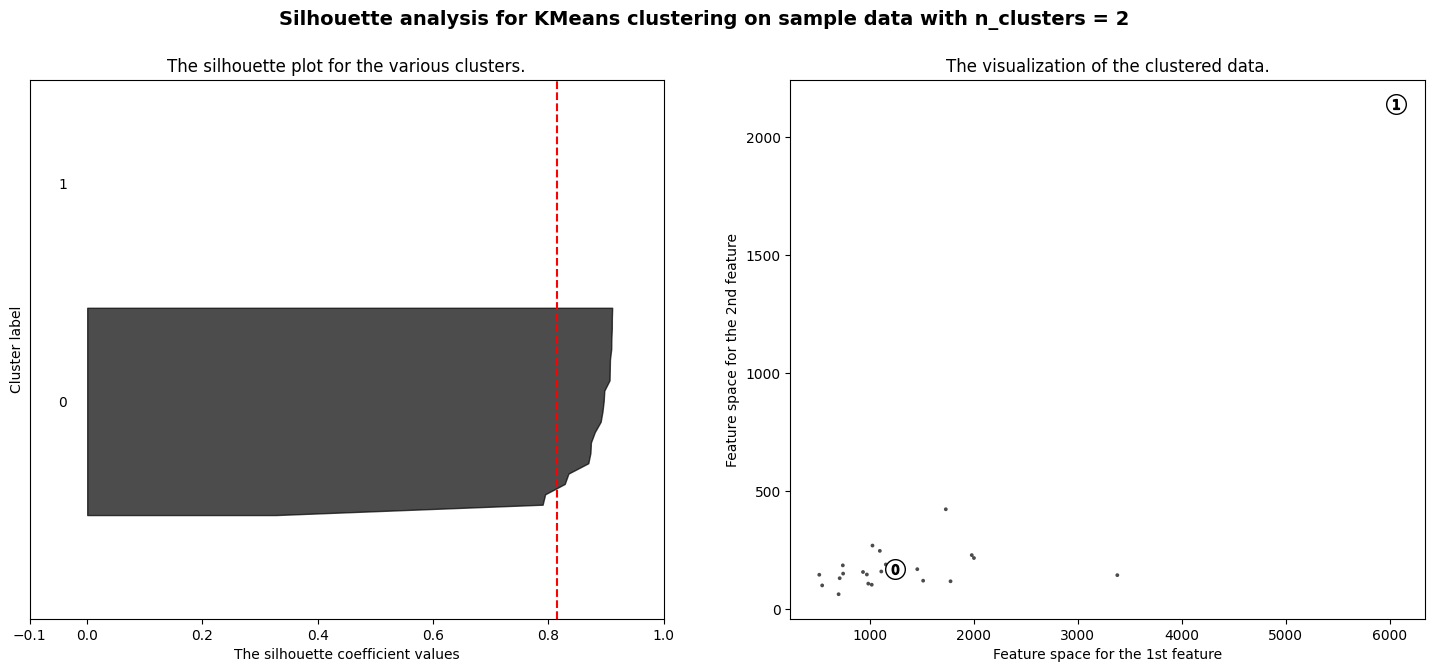

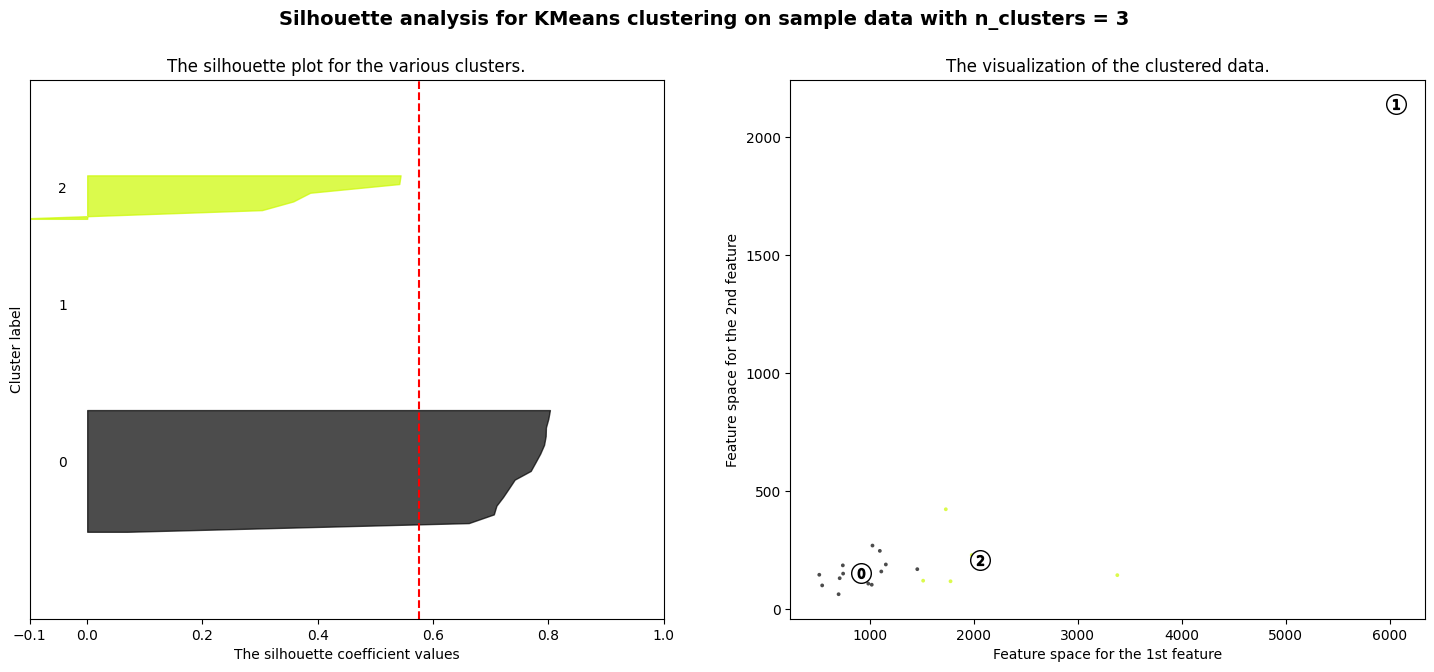

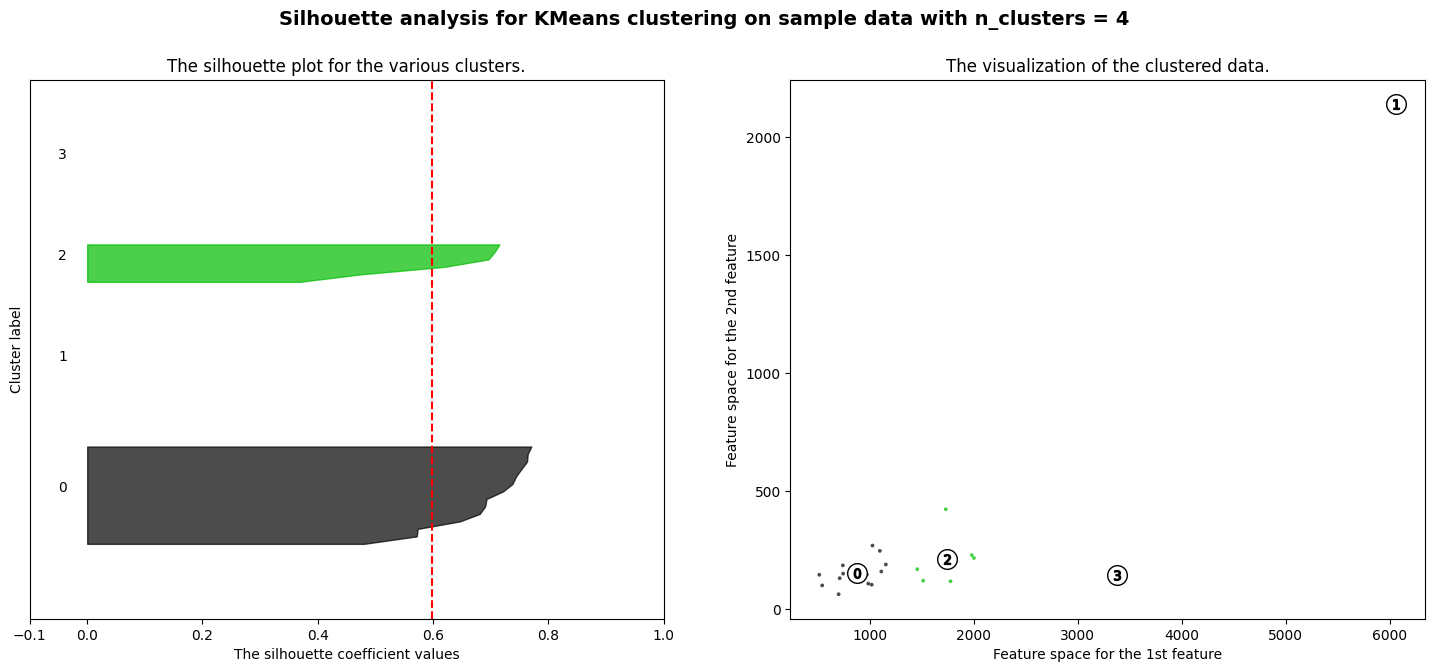

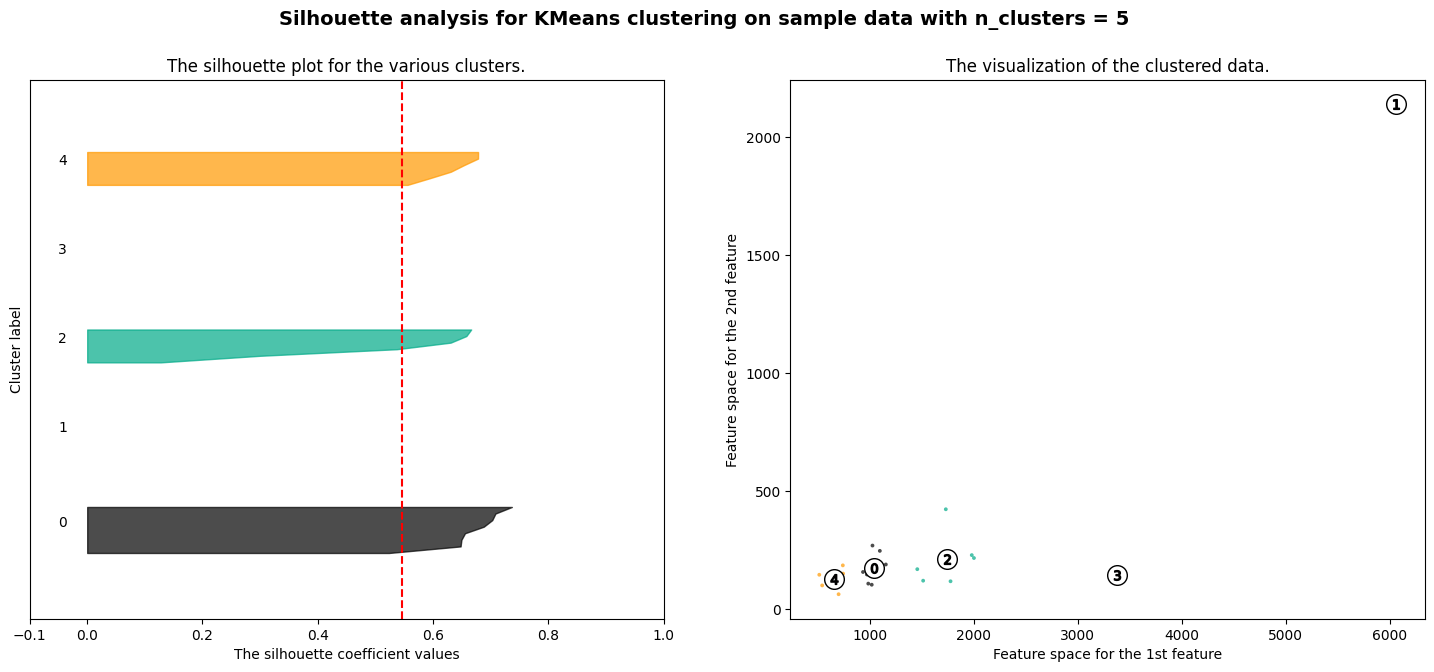

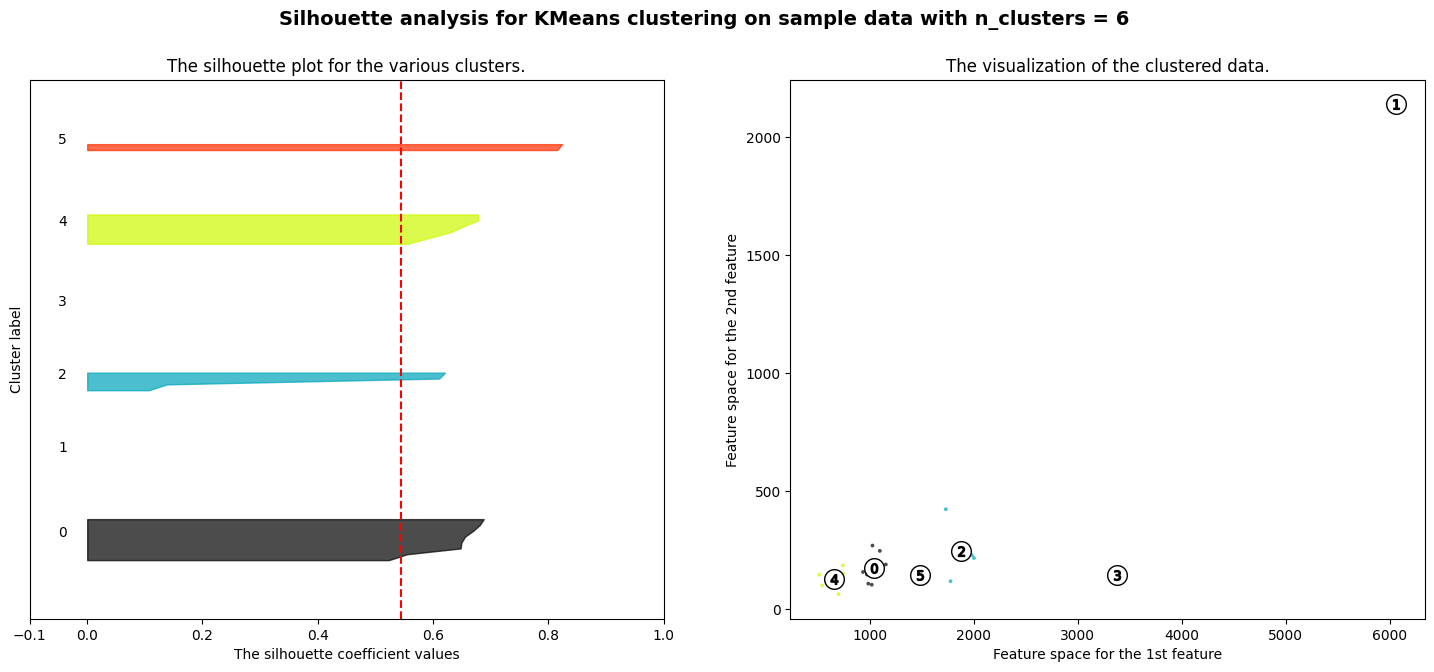

In [9]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### k = 4 es un buen numero

## KMedias y Resultados

In [10]:
km = cluster.KMeans(n_clusters=4).fit(X)
print (km)

KMeans(n_clusters=4)


In [11]:
centroides = km.cluster_centers_
print('Centroide de k = 4\n', centroides)

Centroide de k = 4
 [[1744.35555556  211.68888889]
 [6059.26666667 2138.73333333]
 [ 875.94285714  152.98571429]
 [3381.6         142.86666667]]


In [12]:
labels = km.predict(X_scaled)
departamentos["Cluster"] = km.fit_predict(X_scaled)
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

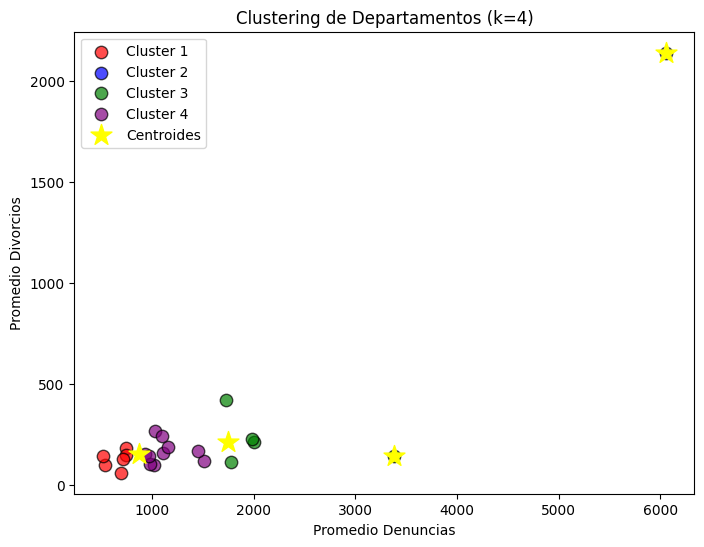

In [13]:
# Crear diagrama de dispersión con clusters
plt.figure(figsize=(8, 6))

# Definir colores para los clusters
colors = ['red', 'blue', 'green', 'purple']
labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

# Graficar cada cluster con su respectivo color
for i in range(4):
    plt.scatter(
        departamentos["Promedio_Denuncias"][departamentos["Cluster"] == i], 
        departamentos["Promedio_Divorcios"][departamentos["Cluster"] == i],
        s=80, c=colors[i], label=labels[i], alpha=0.7, edgecolor="black"
    )

# Graficar los centroides
plt.scatter(
    centroides[:, 0], 
    centroides[:, 1],
    s=250, c="yellow", marker="*", label="Centroides"
)

# Configurar etiquetas y título
plt.xlabel("Promedio Denuncias")
plt.ylabel("Promedio Divorcios")
plt.title("Clustering de Departamentos (k=4)")
plt.legend()

# Mostrar el gráfico
plt.show()

- Se observan 4 grupos bien definidos en la gráfica.
- Un cluster está claramente separado en la esquina superior derecha, lo que indica un departamento con un número de denuncias y divorcios mucho mayor en comparación con los demás. Es probable que este departamento sea Guatemala, ya que tiene la población más alta.
- Hay clusters con departamentos más homogéneos y con valores más cercanos entre sí en la parte baja del gráfico.

- Departamentos con altas denuncias pero bajos divorcios pueden formar un cluster.
- Departamentos con bajas denuncias y bajos divorcios parecen estar en otro cluster.
- Departamentos con niveles intermedios de denuncias y divorcios forman otro grupo.

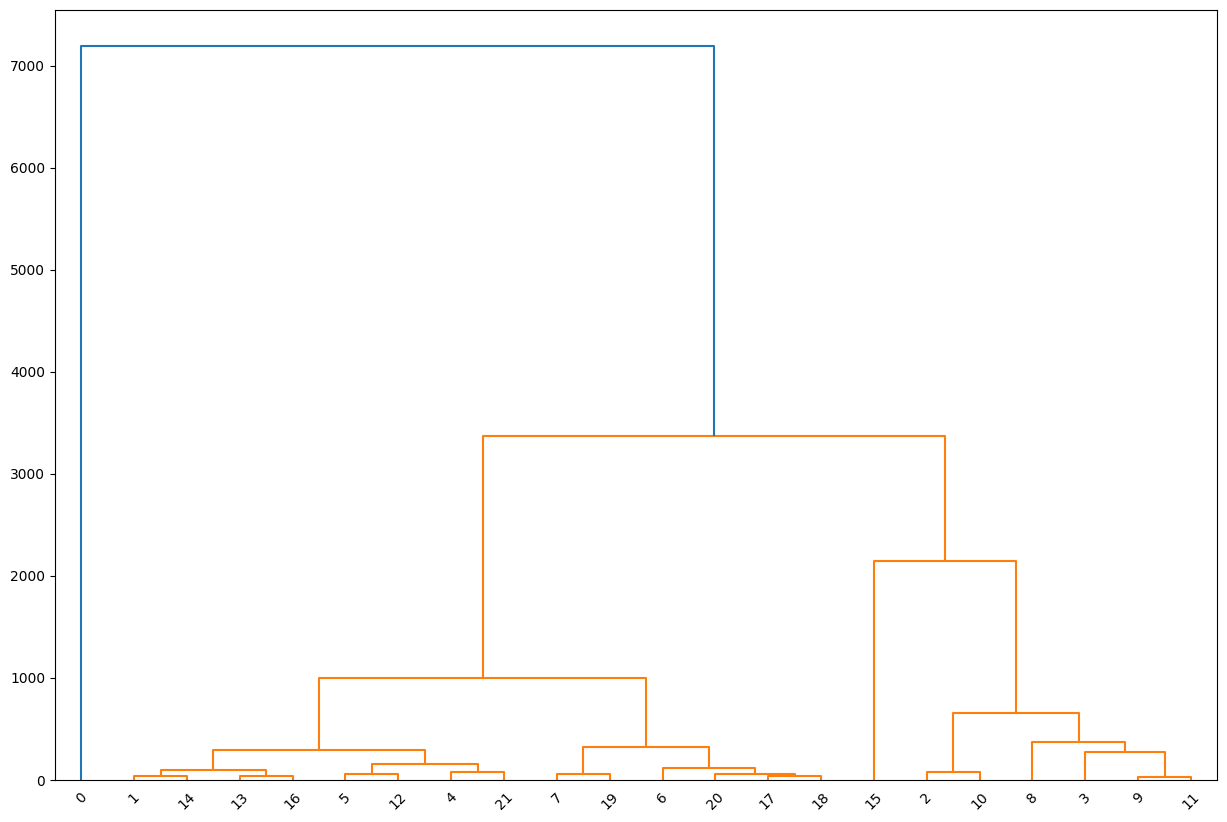

In [14]:
plt.figure(figsize=(15, 10))

dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

- Algunos clusters están muy separados, lo que indica que hay departamentos que se diferencian fuertemente en sus valores de denuncias y divorcios.
- Otros clusters están más compactos, sugiriendo departamentos con características similares.

# CLUSTERING DE VICTIMAS DE VIOLENCIA POR EDAD Y GENERO

### Podremos encontrar patrones en los grupos más afectados, por ejemplo, si ciertas edades presentan más denuncias en un género específico.

In [15]:
por_edad = pd.read_csv("../data/Numero de denuncias de violencia intrafamiliar por grupos quinquenales de edad.csv")
# Cargar nuevamente el dataset de edad para asegurar que esté limpio

df_por_edad = pd.read_csv("../data/Numero de denuncias de violencia intrafamiliar por grupos quinquenales de edad.csv")


# Limpiar los datos (convertir valores con comas en números)
df_por_edad = clean_numeric(df_por_edad)

# Calcular la suma real de los grupos de edad (excluyendo "Total" e "Ignorado" si existen)
columnas_edad = [col for col in df_por_edad.columns if col not in ["Año", "Total"]]
df_por_edad["Total_Corregido"] = df_por_edad[columnas_edad].sum(axis=1)

# Eliminar el total original y actualizar con el total corregido
df_por_edad = df_por_edad.drop(columns=["Total"])
df_por_edad = df_por_edad.rename(columns={"Total_Corregido": "Total"})

df_por_edad = df_por_edad.rename(columns={"Ignorado" : "Ignorado-Edad"})

por_sexo = pd.read_csv("../data/Numero de denuncias de violencia intrafamiliar por sexo de la victima.csv")
por_sexo = clean_numeric(por_sexo)

edad_genero = pd.merge(df_por_edad, por_sexo, on="Año", how="inner")

edad_genero


,Año,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado-Edad,Total_x,Total_y,Hombre,Mujer
0,2008,21,58,178,2211,4354,4707,3937,2787,1925,1196,795,457,286,486,323,23721,23721,2290,21431
1,2009,29,43,221,2748,5955,6190,5154,3816,2472,1682,1039,621,421,757,349,31497,31497,2985,28512
2,2010,36,54,224,2979,5974,6187,5441,3826,2508,1663,1002,612,423,756,332,32017,32017,2858,29159
3,2011,38,48,223,3070,6213,6261,5599,4121,2600,1768,1117,674,472,842,438,33484,33484,2906,30578
4,2012,21,78,242,3373,6825,6823,6081,4402,2795,1774,1172,702,482,877,460,36107,36107,2967,33140
5,2013,26,50,280,3420,6780,6816,6056,4287,2913,1789,1241,727,509,848,428,36170,36170,3252,32918
6,2014,57,86,304,3316,6275,6367,5648,4166,2747,1721,1114,725,538,889,377,34330,34330,3233,31097
7,2015,44,85,275,2895,5998,5972,5162,3985,2505,1539,1046,713,496,915,299,31929,31929,3221,28708
8,2016,41,76,240,2717,5716,5887,5048,3821,2503,1543,1039,715,497,885,462,31190,31190,3295,27895
9,2017,49,83,245,2369,5677,5714,4687,3873,2490,1676,1008,681,500,943,389,30384,30384,3675,26709


In [16]:
import pandas as pd

# Eliminar columnas innecesarias
edad_genero = edad_genero.drop(columns=['Total_x', 'Total_y', 'Ignorado-Edad'], errors='ignore')

# Diccionario para mapear los rangos de edad a valores numéricos
mapa_edad = {
    ' 0  a  4': 0, ' 5  a  9': 1, '10 a 14': 2, '15 a 19': 3, '20 a 24': 4,
    '25 a 29': 5, '30 a 34': 6, '35 a 39': 7, '40 a 44': 8, '45 a 49': 9,
    '50 a 54': 10, '55 a 59': 11, '60 a 64': 12, '65 y más': 13
}

# Verificar qué columnas de edad existen en el DataFrame
columnas_edad = [col for col in edad_genero.columns if col in mapa_edad]

# Reorganizar el dataset correctamente
nueva_estructura = []

for index, row in edad_genero.iterrows():
    año = row['Año']  # Obtener el año
    total_hombres = row['Hombre']
    total_mujeres = row['Mujer']
    total_victimas = total_hombres + total_mujeres  # Suma total para evitar división por cero

    for columna in columnas_edad:  # Iterar sobre todas las edades detectadas
        edad_categoria = mapa_edad[columna]
        cantidad_total = row[columna]  # Número de víctimas en ese rango de edad

        # Evitar división por cero si no hay víctimas en ese rango de edad
        if total_victimas > 0:
            cantidad_hombres = int(cantidad_total * (total_hombres / total_victimas))
            cantidad_mujeres = int(cantidad_total * (total_mujeres / total_victimas))
        else:
            cantidad_hombres = 0
            cantidad_mujeres = 0

        nueva_estructura.append([año, edad_categoria, 'Hombre', cantidad_hombres])  
        nueva_estructura.append([año, edad_categoria, 'Mujer', cantidad_mujeres])  

# Crear un nuevo DataFrame con la estructura correcta
nuevo_edad_genero = pd.DataFrame(nueva_estructura, columns=['Año', 'Edad', 'Género', 'Cantidad'])

# Mostrar las filas del nuevo dataset
nuevo_edad_genero


,Año,Edad,Género,Cantidad
0,2008,0,Hombre,2
1,2008,0,Mujer,18
2,2008,1,Hombre,5
3,2008,1,Mujer,52
4,2008,2,Hombre,17
...,...,...,...,...
415,2022,11,Mujer,919
416,2022,12,Hombre,116
417,2022,12,Mujer,675
418,2022,13,Hombre,234


## Histograma multiple variables

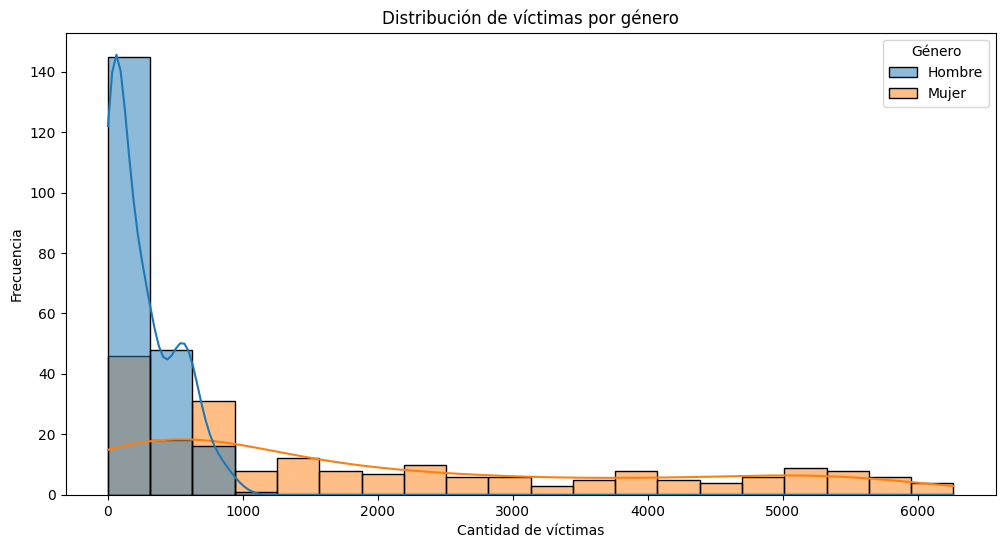

In [17]:
import seaborn as sns

# Crear histogramas separados por género
plt.figure(figsize=(12, 6))
sns.histplot(nuevo_edad_genero, x="Cantidad", hue="Género", bins=20, kde=True)

plt.title("Distribución de víctimas por género")
plt.xlabel("Cantidad de víctimas")
plt.ylabel("Frecuencia")
plt.show()

## Estadistico de Hopkings

In [18]:
Y = np.array(nuevo_edad_genero[['Género']])
X = np.array(nuevo_edad_genero[['Edad', 'Cantidad']])
X.shape

(420, 2)

In [19]:
random.seed(123)

X_scaled2 = sklearn.preprocessing.scale(X)

# Calcular la Estadística de Hopkins
hopkins_value = hopkins_statistic(X_scaled2, len(X_scaled2))
print(f'Estadística de Hopkins: {hopkins_value}')

Estadística de Hopkins: 0.0


## Numero de Clusters

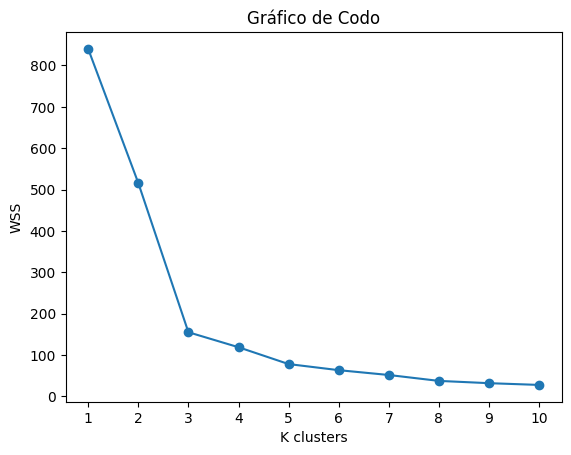

In [20]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scaled2)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

### Parece que k = 3 es buen numero

## Analisis de Silhoutte

For n_clusters = 2 The average silhouette_score is : 0.806873448373142
For n_clusters = 3 The average silhouette_score is : 0.7541928497961489
For n_clusters = 4 The average silhouette_score is : 0.727514923624919
For n_clusters = 5 The average silhouette_score is : 0.6518549733908893
For n_clusters = 6 The average silhouette_score is : 0.6588676910623184


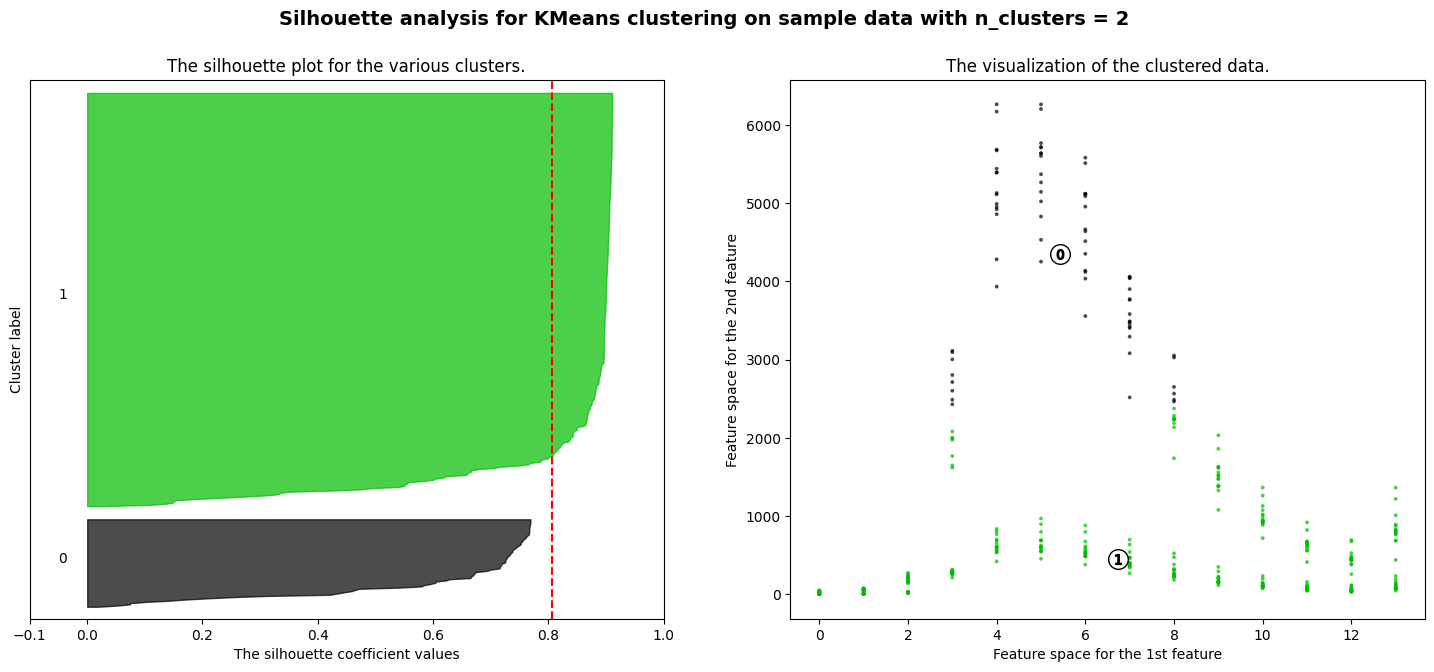

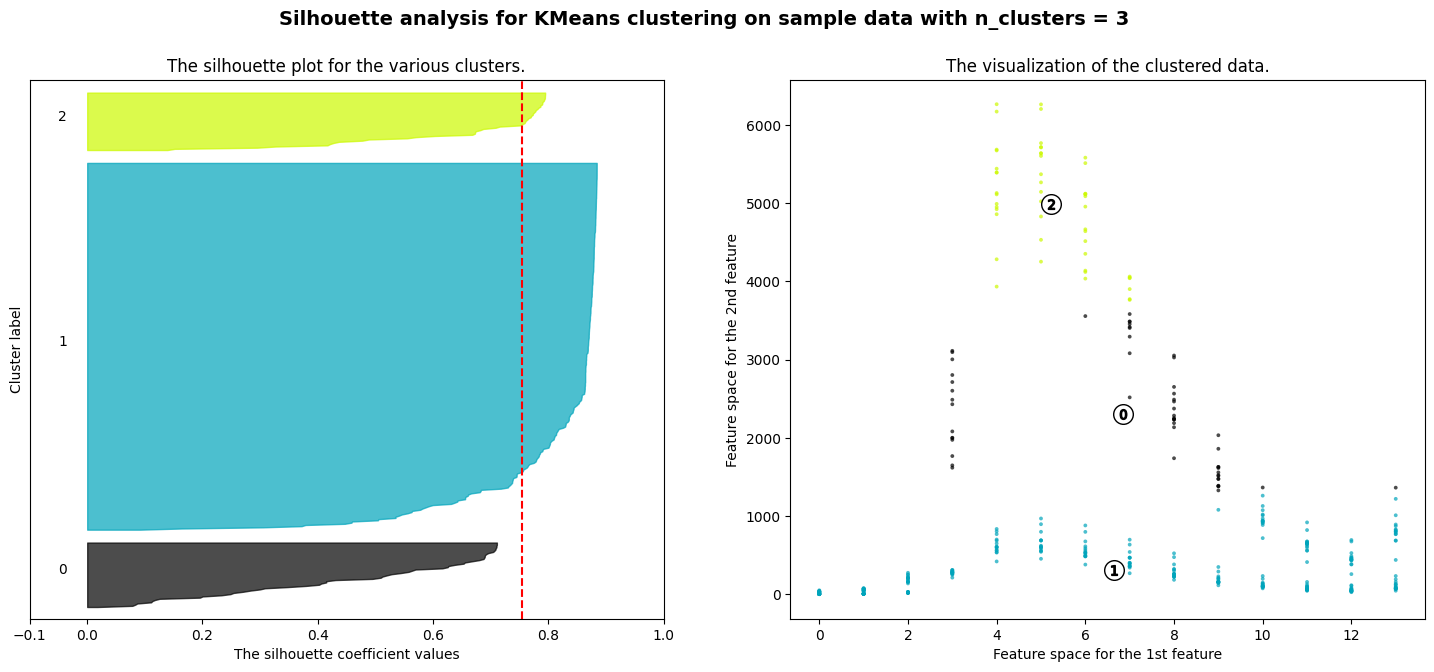

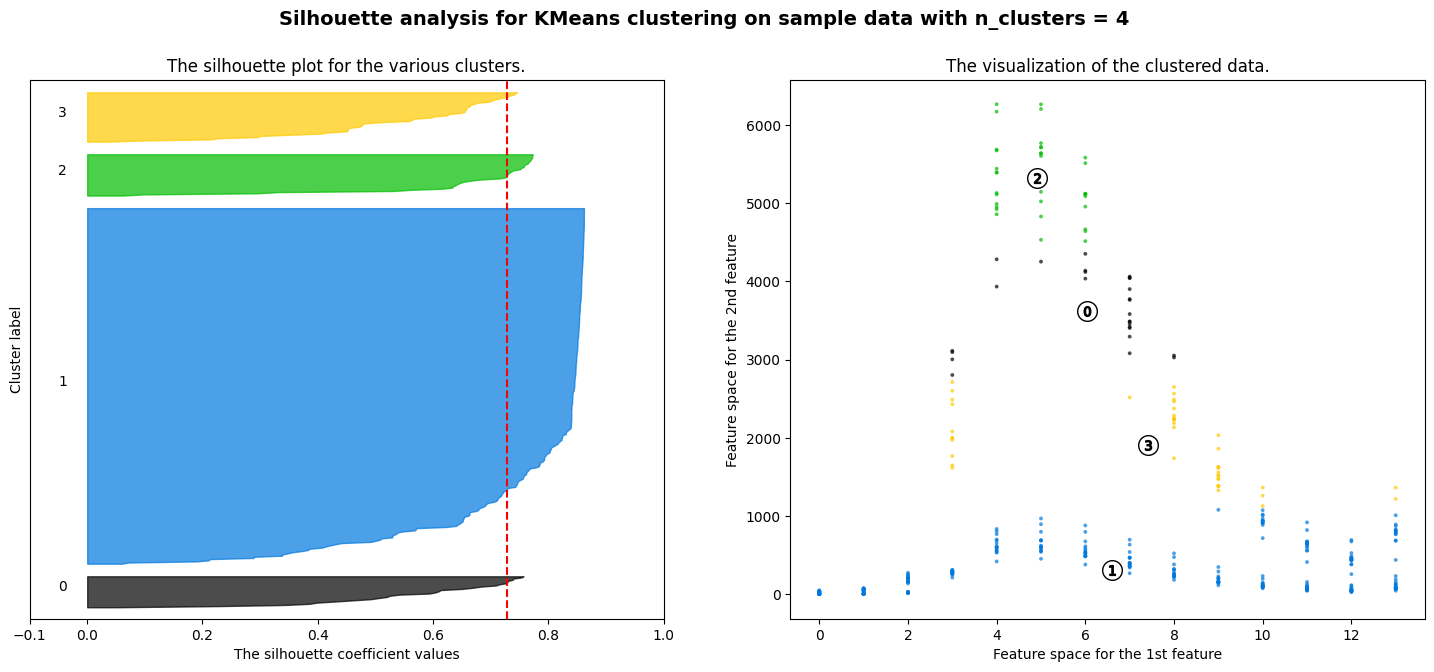

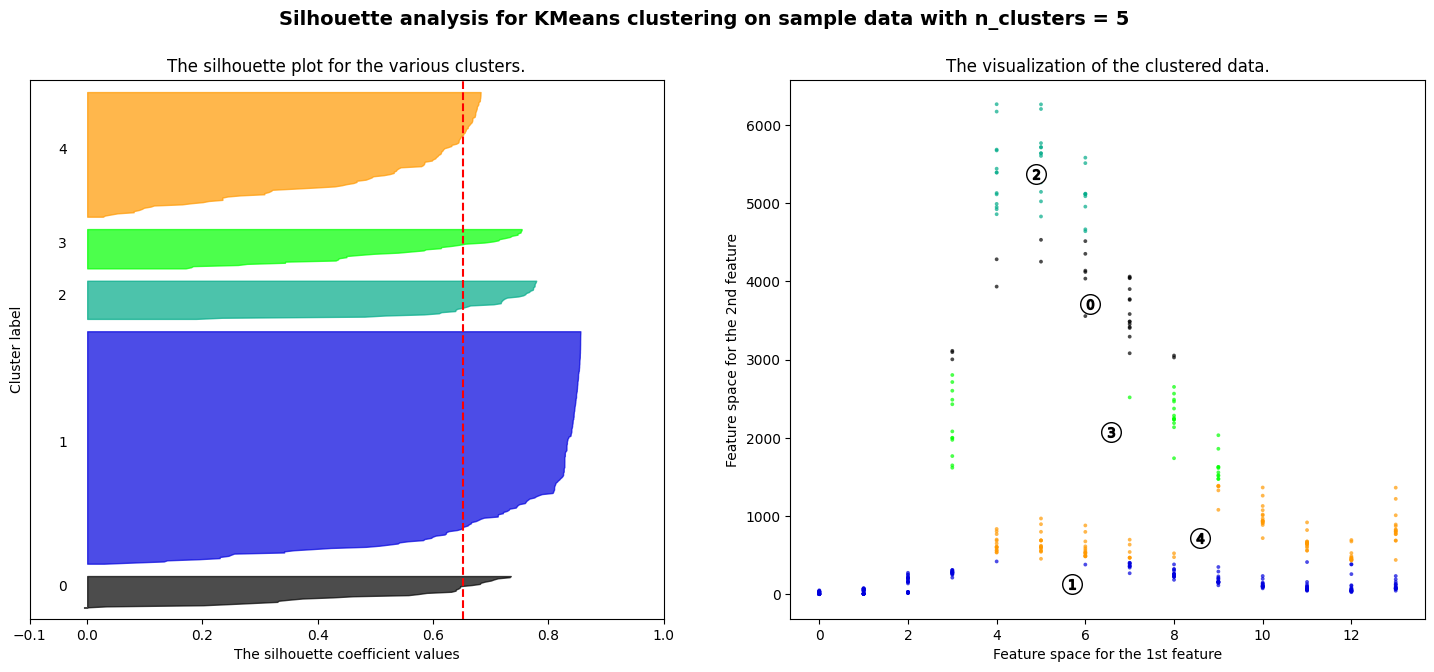

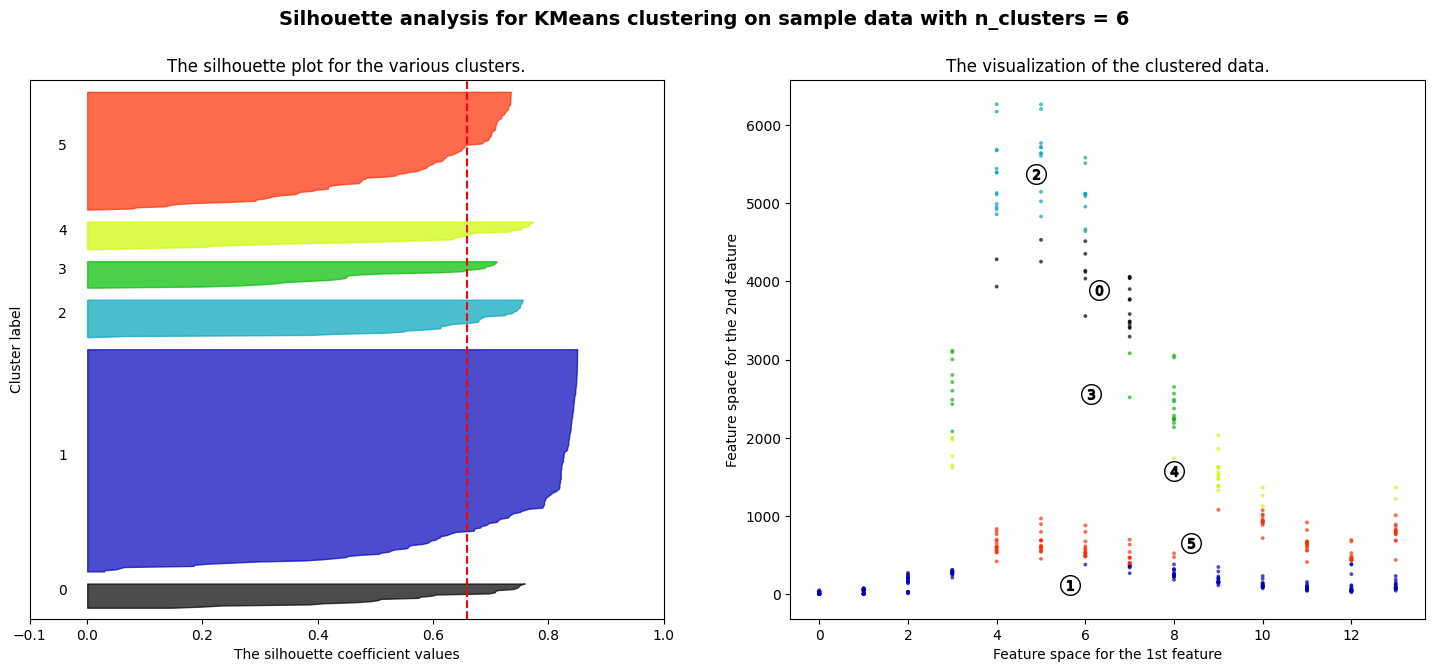

In [21]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### Para que no quede ajustado y tan pocos los clusters, sera k = 3

## K Medias y Resultados

In [22]:
scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)
km = KMeans(n_clusters=3, random_state=42, n_init=10)
km.fit(X_scaled2)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [23]:
centroides_scaled = km.cluster_centers_
centroides = scaler.inverse_transform(centroides_scaled)
print('Centroide de k = 3\n', centroides)

Centroide de k = 3
 [[1.02774869e+01 5.83256545e+02]
 [2.43396226e+00 3.45509434e+02]
 [5.42857143e+00 4.45101429e+03]]


In [24]:
labels = km.predict(X_scaled2)
nuevo_edad_genero["Cluster"] = km.fit_predict(X_scaled2)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,

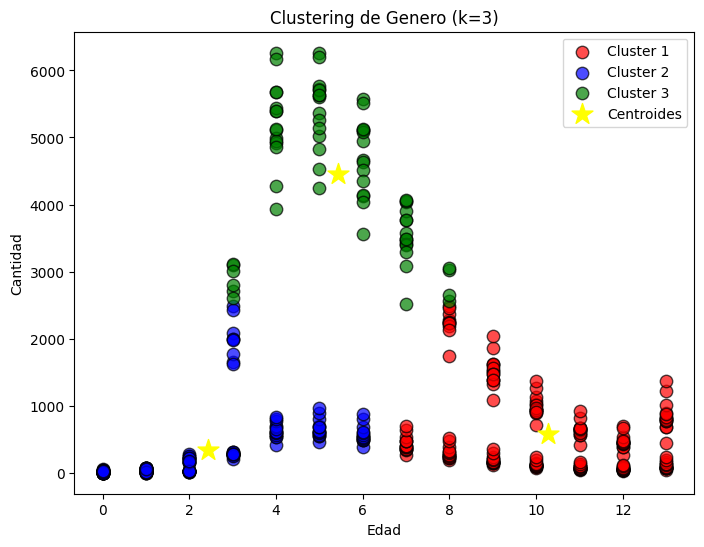

In [25]:
# Crear diagrama de dispersión con clusters
plt.figure(figsize=(8, 6))

# Definir colores para los clusters
colors = ['red', 'blue', 'green']
labels = ["Cluster 1", "Cluster 2", "Cluster 3"]

# Graficar cada cluster con su respectivo color
for i in range(3):
    plt.scatter(
        nuevo_edad_genero["Edad"][nuevo_edad_genero["Cluster"] == i], 
        nuevo_edad_genero["Cantidad"][nuevo_edad_genero["Cluster"] == i],
        s=80, c=colors[i], label=labels[i], alpha=0.7, edgecolor="black"
    )

# Graficar los centroides
plt.scatter(
    centroides[:, 0], 
    centroides[:, 1],
    s=250, c="yellow", marker="*", label="Centroides"
)

# Configurar etiquetas y título
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.title("Clustering de Genero (k=3)")
plt.legend()

# Mostrar el gráfico
plt.show()

- Existe una relación entre la edad y la cantidad de víctimas.
- La mayoría de las víctimas están en edades intermedias (Cluster verde), lo que indica que este grupo es el más afectado.
- Las edades más bajas y más altas tienen una menor cantidad de víctimas, pero siguen siendo relevantes para el análisis.
- Los centroides están bien posicionados, reflejando los puntos con mayor densidad en cada grupo.

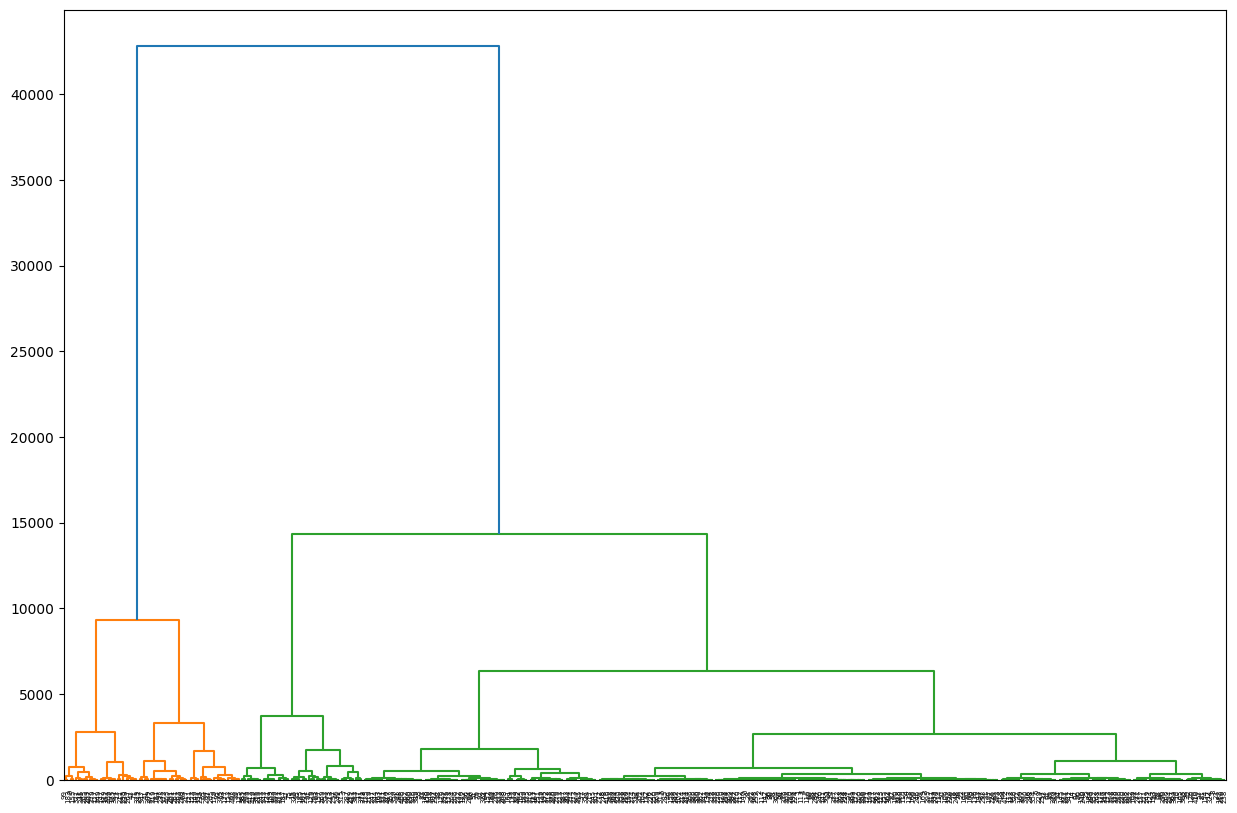

In [26]:
plt.figure(figsize=(15, 10))

dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

- La estructura jerárquica refuerza los resultados de K-Means, ya que los datos tienden a agruparse de forma natural en tres clusters.
- Si se quisiera probar otra cantidad de clusters, el dendrograma sugiere que 2 o 3 clusters serían óptimos, pero más de 4 no aportaría mucho valor.
- El dendrograma confirma que hay una alta variabilidad en la cantidad de víctimas por edad, lo que justifica la aplicación de clustering para segmentar la información.

# CLUSTERING DE TIPOS DE VIOLENCIA

### Aplicar clustering aquí nos permitirá identificar grupos de violencia comunes (por ejemplo, si violencia psicológica y física suelen ocurrir juntas en ciertos patrones).

In [27]:
tipo_agresion = pd.read_csv("../data/Numero de denuncias de violencia intrafamiliar por tipo de agresion sufrida.csv")
tipo_agresion = clean_numeric(tipo_agresion)
tipo_agresion

,Año,Total,Física,Psicológica,Sexual,Patrimonial,Física - psicológica,Física - sexual,Física - patrimonial,Psicológica - sexual,Psicológica - patrimonial,Sexual - patrimonial,Física - psicológica - sexual,Física - psicológica - patrimonial,Psicológica - sexual - patrimonial,Física - sexual - patrimonial,Física - psico - sexual - patrimonial
0,2008,23721,3765,6111,49,310,9572,56,115,83,1116,1,339,1912,28,7,257
1,2009,31497,4133,8552,78,449,13371,85,127,121,1519,7,450,2305,18,10,272
2,2010,32017,4177,8145,65,296,14267,63,133,140,1326,5,445,2606,29,10,310
3,2011,33484,4014,9279,73,308,14425,61,164,128,1521,5,443,2718,41,8,296
4,2012,36107,3841,10190,72,305,15735,66,149,121,1710,4,479,3101,25,7,302
5,2013,36170,4050,11188,94,265,14741,57,108,130,1850,6,439,2962,33,7,240
6,2014,34330,3632,10864,131,222,13783,53,84,153,1835,11,383,2942,21,3,213
7,2015,31929,3584,10664,105,451,12528,62,63,154,1357,3,295,2446,21,11,185
8,2016,31190,3972,10729,101,459,11570,59,84,111,1445,2,249,2269,11,8,121
9,2017,30384,3713,11993,150,435,10363,64,63,132,1420,8,234,1667,28,6,108


In [28]:
# Eliminar la columna "Total" ya que no aporta información relevante para clustering
tipo_agresion = tipo_agresion.drop(columns=["Total"], errors="ignore")

# Convertir el dataset a formato largo (melt)
tipo_agresion_long = tipo_agresion.melt(id_vars=["Año"], var_name="Tipo_violencia", value_name="Cantidad_total")

tipo_agresion_long

,Año,Tipo_violencia,Cantidad_total
0,2008,Física,3765
1,2009,Física,4133
2,2010,Física,4177
3,2011,Física,4014
4,2012,Física,3841
...,...,...,...
220,2018,Física - psico - sexual - patrimonial,117
221,2019,Física - psico - sexual - patrimonial,113
222,2020,Física - psico - sexual - patrimonial,82
223,2021,Física - psico - sexual - patrimonial,93


## Histograma de variable multiple

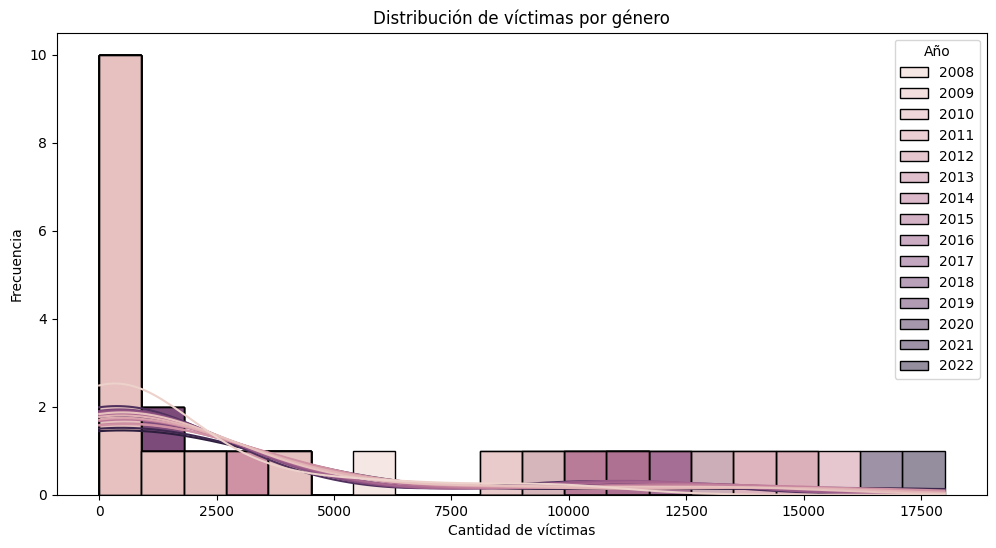

In [29]:
# Crear histogramas separados por género
plt.figure(figsize=(12, 6))
sns.histplot(tipo_agresion_long, x="Cantidad_total", hue="Año", bins=20, kde=True)

plt.title("Distribución de víctimas por género")
plt.xlabel("Cantidad de víctimas")
plt.ylabel("Frecuencia")
plt.show()

## Estadistico Hopkings

In [31]:
Y = np.array(tipo_agresion_long[['Tipo_violencia']])
X = np.array(tipo_agresion_long[['Año', 'Cantidad_total']])
X.shape

(225, 2)

In [32]:
random.seed(123)

X_scaled2 = sklearn.preprocessing.scale(X)

# Calcular la Estadística de Hopkins
hopkins_value = hopkins_statistic(X_scaled2, len(X_scaled2))
print(f'Estadística de Hopkins: {hopkins_value}')

Estadística de Hopkins: 0.0


## Numero k de clusters

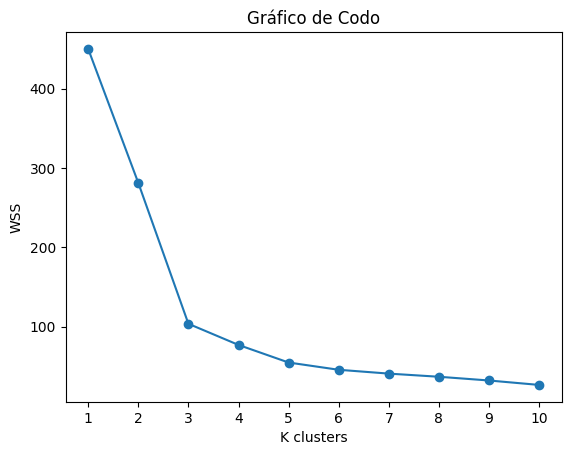

In [33]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scaled2)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

### el k = 4 parece ser un buen numero

## Analisis de Silhoutte

For n_clusters = 2 The average silhouette_score is : 0.8789547553069087
For n_clusters = 3 The average silhouette_score is : 0.7946006324891177
For n_clusters = 4 The average silhouette_score is : 0.785834656142216
For n_clusters = 5 The average silhouette_score is : 0.8209274082410634
For n_clusters = 6 The average silhouette_score is : 0.8090712022389366


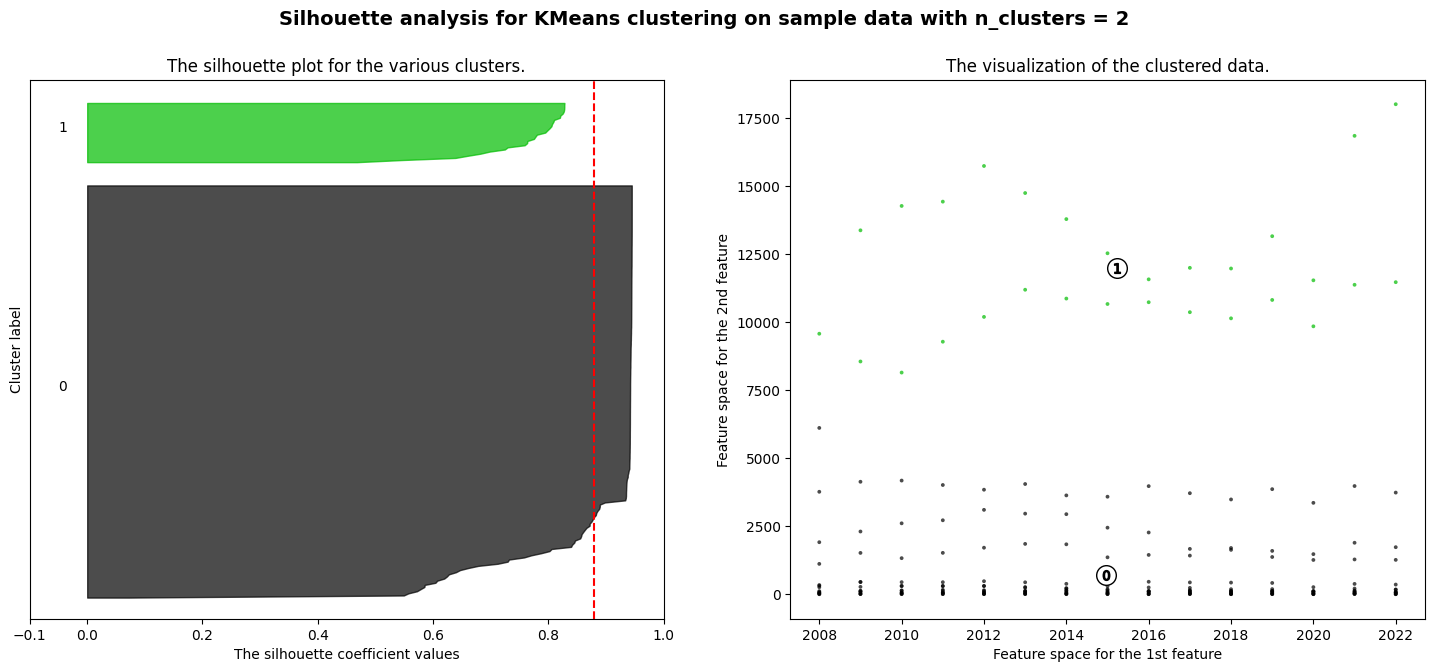

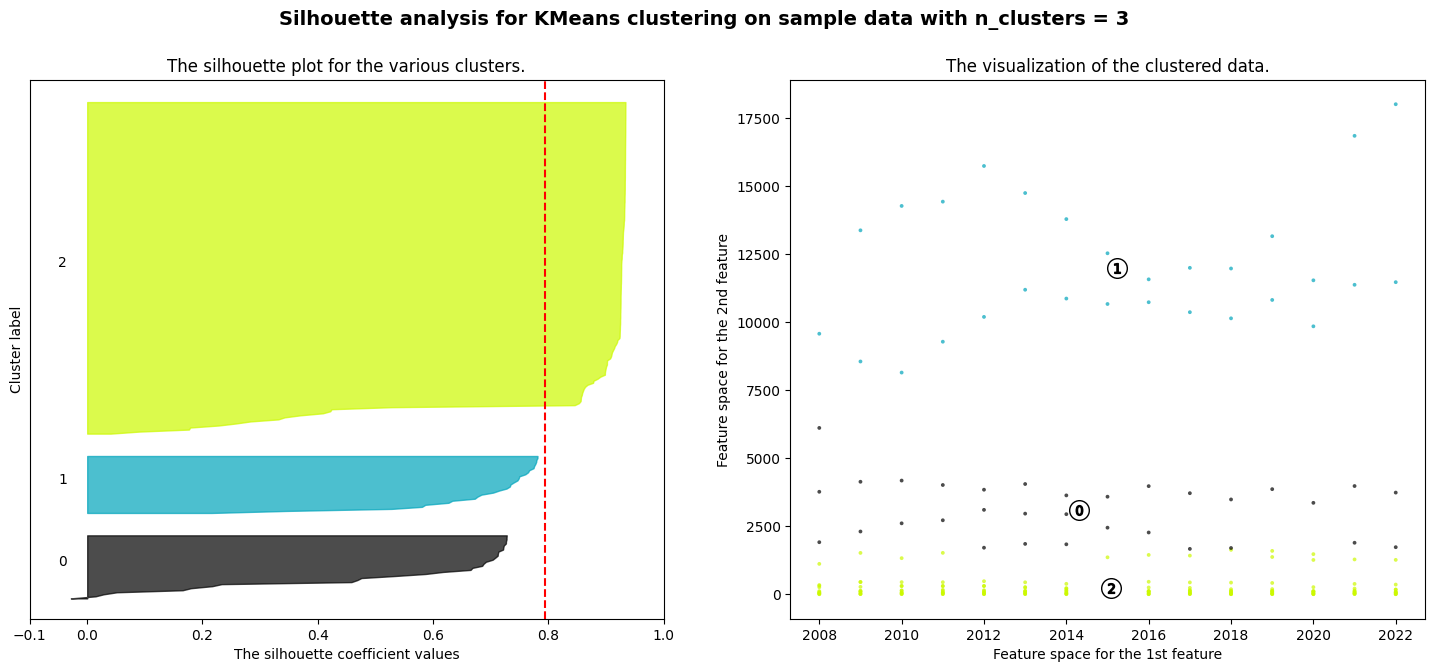

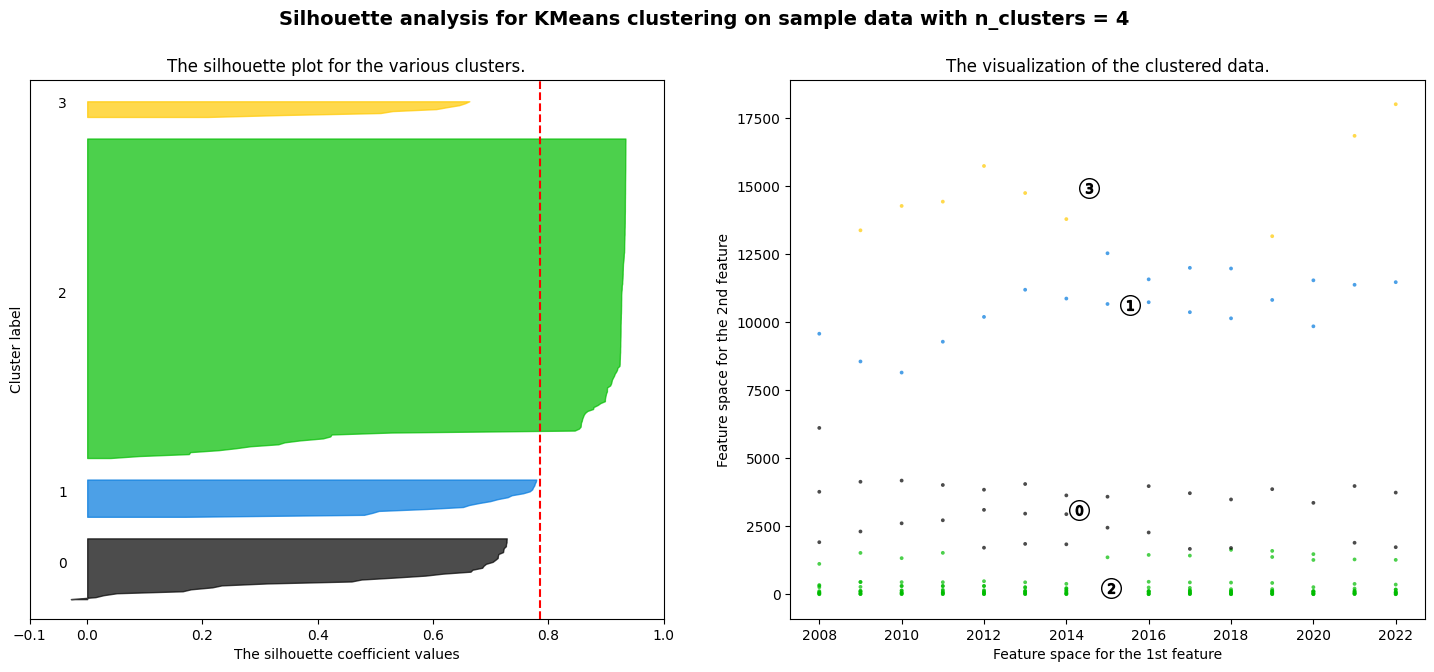

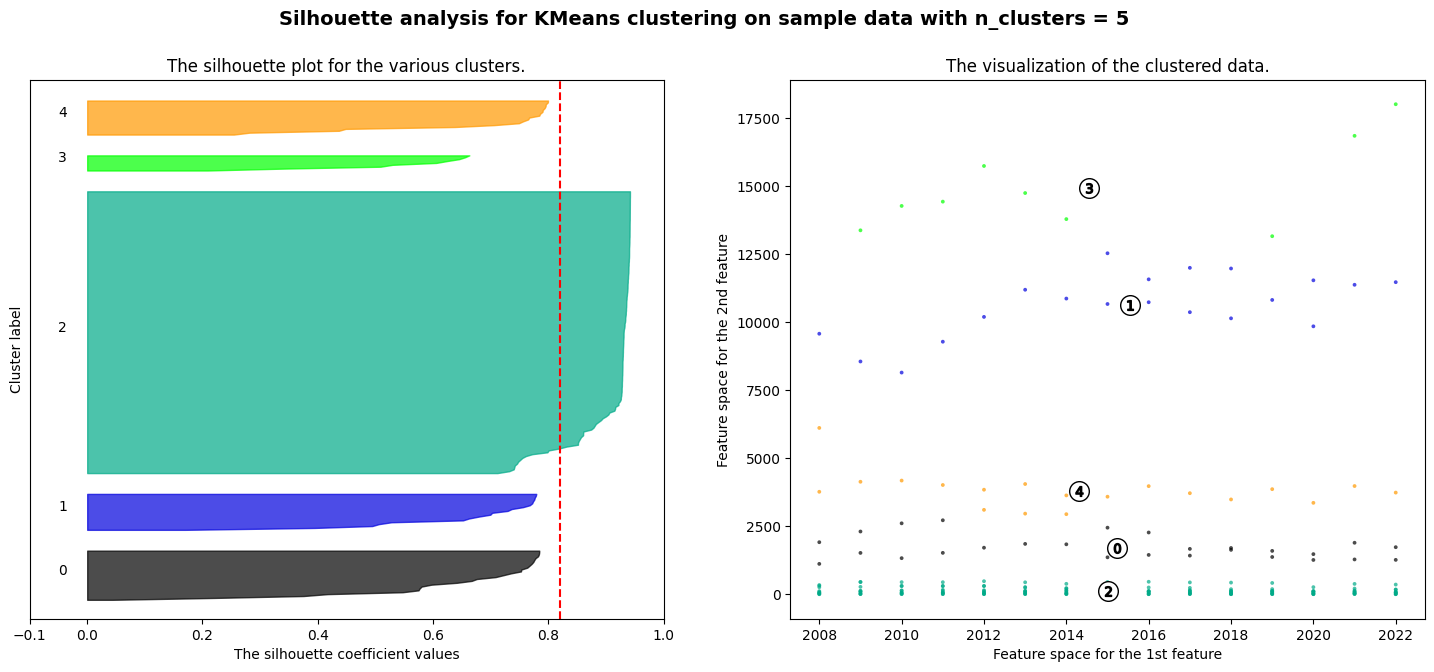

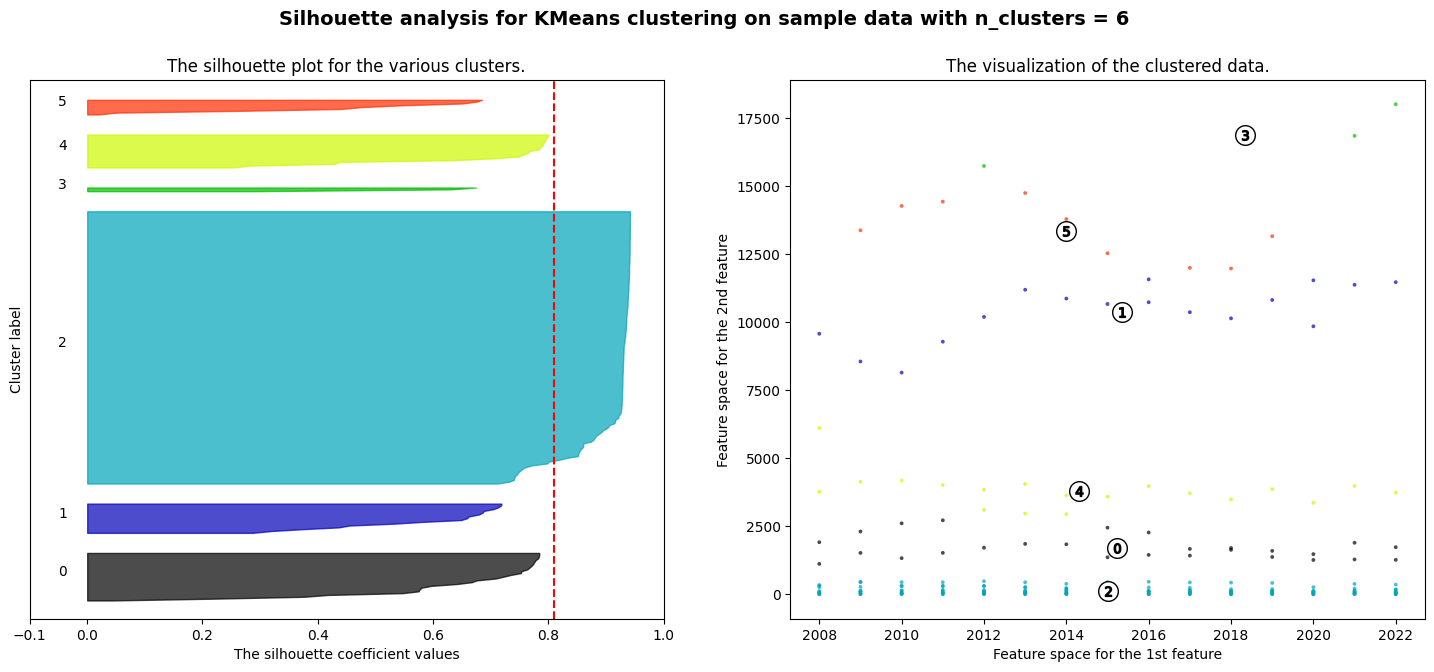

In [34]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### Al hacer la prueba de la silueta, se puede resumir que k = 5

## K Medias y Resultados

In [35]:
scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)
km = KMeans(n_clusters=5, random_state=42, n_init=10)
km.fit(X_scaled2)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [36]:
centroides_scaled = km.cluster_centers_
centroides = scaler.inverse_transform(centroides_scaled)
print('Centroide de k = 5\n', centroides)

Centroide de k = 5
 [[ 2009.47169811   813.35849057]
 [ 2019.5          598.35897436]
 [ 2011.73333333 11820.26666667]
 [ 2014.           734.36923077]
 [ 2019.         12127.78571429]]


In [37]:
labels = km.predict(X_scaled2)
tipo_agresion_long["Cluster"] = km.fit_predict(X_scaled2)
labels

array([0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1], dtype=int32)

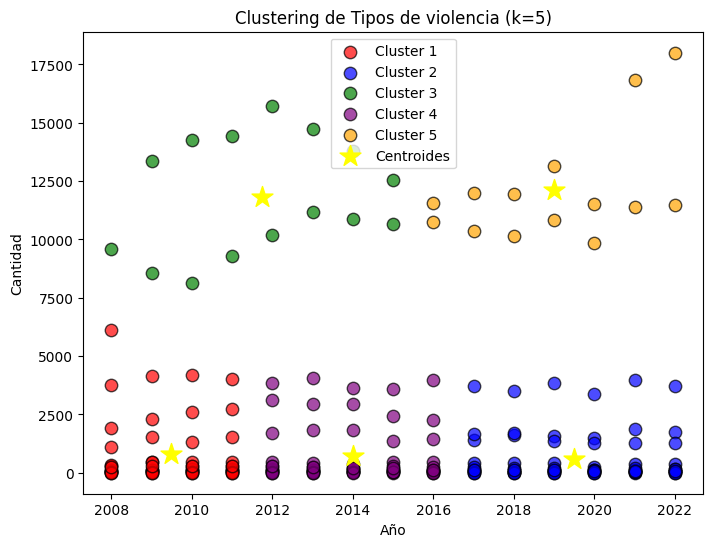

In [40]:
# Crear diagrama de dispersión con clusters
plt.figure(figsize=(8, 6))

# Definir colores para los clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]

# Graficar cada cluster con su respectivo color
for i in range(5):
    plt.scatter(
        tipo_agresion_long["Año"][tipo_agresion_long["Cluster"] == i], 
        tipo_agresion_long["Cantidad_total"][tipo_agresion_long["Cluster"] == i],
        s=80, c=colors[i], label=labels[i], alpha=0.7, edgecolor="black"
    )

# Graficar los centroides
plt.scatter(
    centroides[:, 0], 
    centroides[:, 1],
    s=250, c="yellow", marker="*", label="Centroides"
)

# Configurar etiquetas y título
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.title("Clustering de Tipos de violencia (k=5)")
plt.legend()

# Mostrar el gráfico
plt.show()

- El tipo de violencia con mayor número de casos (cluster verde) se mantiene en un rango alto, con algunos cambios a lo largo del tiempo.
- Los clusters rojos y morados muestran tipos de violencia que han mantenido valores más bajos y estables.
- El cluster naranja indica un posible crecimiento reciente de ciertos tipos de violencia en los últimos años, lo que podría requerir una mayor intervención.
- El clustering ayuda a identificar patrones y tendencias en la violencia a lo largo del tiempo, permitiendo priorizar estrategias de prevención y atención.

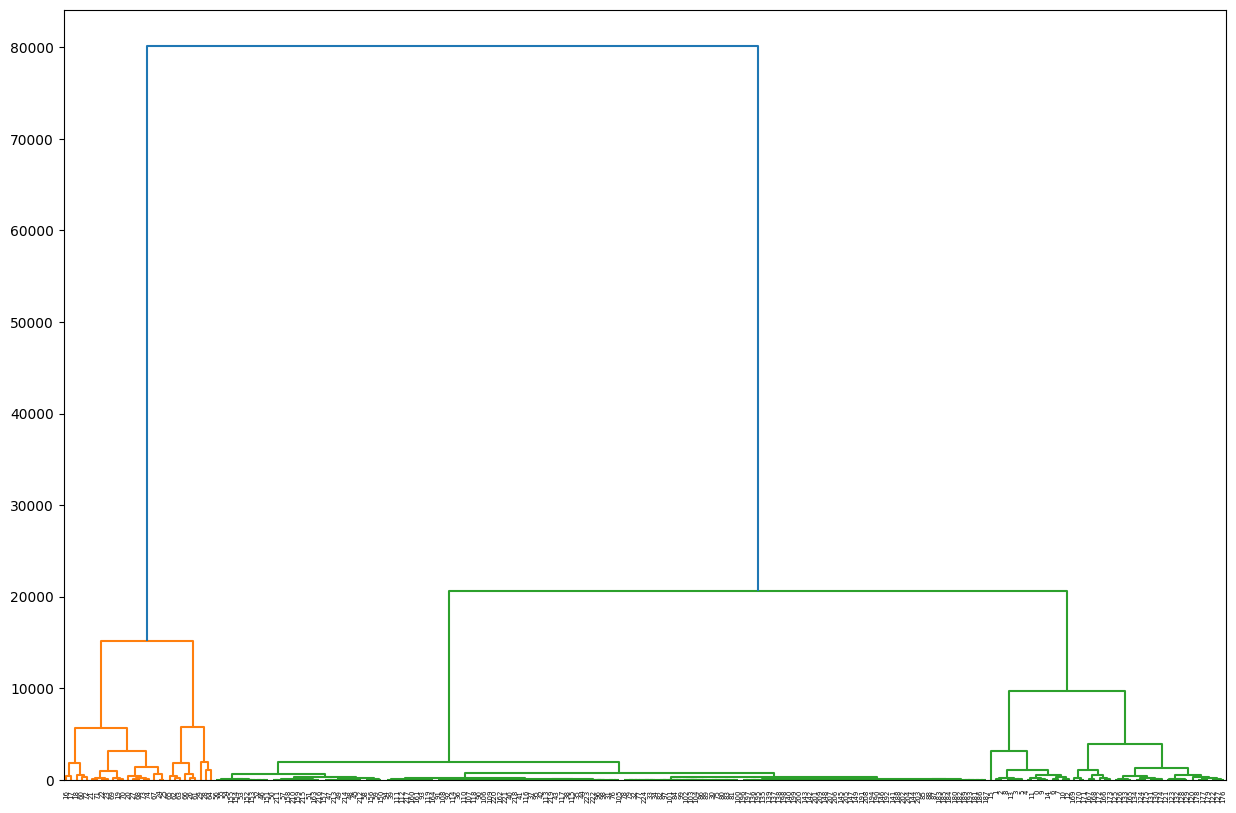

In [41]:
plt.figure(figsize=(15, 10))

dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

- Existen al menos 3 grandes grupos naturales de tipos de violencia que se diferencian claramente.
- Esto confirma que el uso de 5 clusters en K-Means es razonable, aunque también podríamos probar con 3 para ver cómo cambia la segmentación.
- La estructura jerárquica refuerza la idea de que algunos tipos de violencia están más relacionados entre sí que otros.

# CLUSTERING GENERAL DE DIVORCIO Y VIOLENCIA

### Podemos hacer clustering para analizar tendencias generales.

In [ ]:
divorcios_intrafamiliar = pd.read_csv("../data/divorcios_violencia_intrafamiliar.csv")
divorcios_intrafamiliar = clean_numeric(divorcios_intrafamiliar)
divorcios_intrafamiliar

,Año,Total_Divorcios_Republica,Total_Denuncias_Intrafamiliar_República,Guatemala_Divorcios,Guatemala_Denuncias,El Progreso_Divorcios,El Progreso_Denuncias,Sacatepéquez_Divorcios,Sacatepéquez_Denuncias,Chimaltenango_Divorcios,...,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado-Edad
0,2008,2834,23721,1052,5117,45,978,80,926,58,...,4707,3937,2787,1925,1196,795,457,286,486,323
1,2009,3004,31497,1140,6692,41,1108,77,1368,59,...,6190,5154,3816,2472,1682,1039,621,421,757,349
2,2010,3645,32017,1561,5792,63,1101,61,1356,38,...,6187,5441,3826,2508,1663,1002,612,423,756,332
3,2011,4344,33484,1798,6122,82,1101,72,1492,57,...,6261,5599,4121,2600,1768,1117,674,472,842,438
4,2012,5157,36107,2152,6911,89,1039,71,1651,67,...,6823,6081,4402,2795,1774,1172,702,482,877,460
5,2013,5542,36170,2261,6581,86,1142,122,1783,82,...,6816,6056,4287,2913,1789,1241,727,509,848,428
6,2014,5575,34330,2044,5777,114,1081,138,1584,124,...,6367,5648,4166,2747,1721,1114,725,538,889,377
7,2015,5726,31929,2185,6410,98,883,115,1613,125,...,5972,5162,3985,2505,1539,1046,713,496,915,299
8,2016,5665,31190,2142,6053,95,675,133,1477,106,...,5887,5048,3821,2503,1543,1039,715,497,885,462
9,2017,5808,30384,2075,5451,108,825,154,1623,129,...,5714,4687,3873,2490,1676,1008,681,500,943,389
